## MODEL LSTM

In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

PREPROCESSAMENT DE DADES

In [2]:

# Carregar dataset
df = pd.read_csv("Conjunt de dades Preprocessades/Datasets/Amazon_Stock_Price_output.csv")

# Assegurar ordre cronològic
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values("Date", inplace=True)

# Definir columnes d'entrada i sortida
FEATURE_COLUMNS = [
    "Open", "High", "Low", "Volume",
    "EMA_7", "EMA_40", "MACD", "Signal_Line",
    "MACD_Hist", "RSI", "ATR"
]
TARGET_COLUMN = "Close"

# Eliminar files amb valors nuls
df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN], inplace=True)

# Extreure matrius X i y
data_X = df[FEATURE_COLUMNS].values
data_y = df[TARGET_COLUMN].values.reshape(-1, 1)

# Funció per crear seqüències temporals
def create_sequences(X, y, n_steps=30):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i - n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

N_STEPS = 30
X_seq, y_seq = create_sequences(data_X, data_y, n_steps=N_STEPS)

# Definir proporcions per a train/val/test (80%/10%/10%)
n_total    = len(X_seq)
train_size = int(n_total * 0.80)
val_size   = int(n_total * 0.10)
test_size  = n_total - train_size - val_size

# Separació temporal
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

# Inicialitzar escaladors
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Escalar les entrades
ns_train, nt, nf = X_train.shape

# Ajustar i transformar X_train
X_train_flat = X_train.reshape(ns_train * nt, nf)
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(ns_train, nt, nf)

# Transformar X_val
ns_val = X_val.shape[0]
X_val_flat = X_val.reshape(ns_val * nt, nf)
X_val_scaled_flat = scaler_X.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(ns_val, nt, nf)

# Transformar X_test
ns_test = X_test.shape[0]
X_test_flat = X_test.reshape(ns_test * nt, nf)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(ns_test, nt, nf)

# Escalar les sortides (y)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)


In [3]:
# Funció per generar Data Augmentation
def augment_with_noise(X, y, noise_level=0.01, n_augments=3):
    X_augmented = [X]
    y_augmented = [y]
    for _ in range(n_augments):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_noisy = X + noise
        X_augmented.append(X_noisy)
        y_augmented.append(y)
    X_combined = np.concatenate(X_augmented, axis=0)
    y_combined = np.concatenate(y_augmented, axis=0)
    return X_combined, y_combined

# Aplicar augmentació al conjunt d'entrenament
X_train_scaled, y_train_scaled = augment_with_noise(
    X_train_scaled,
    y_train_scaled,
    noise_level=0.01,
    n_augments=3
)

In [ ]:
# Funció per calcular mètriques
def compute_metrics(model, X_scaled, y_scaled, scaler_y, dataset_name="Dataset"):
    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_scaled)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- Mètriques per a {dataset_name} ---")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")
    return y_true, y_pred, mae, rmse, r2

CONSTRUCCIÓ MODEL LSTM AMB CERCA ALEATÒRIA MANUAL D'HIPERPARÀMETRES

In [ ]:

def build_lstm_model_params(sequence_length, n_features, units, n_layers, dropout, learning_rate):
    model = Sequential()
    for i in range(n_layers):
        is_first = (i == 0)
        is_last = (i == n_layers - 1)
        return_sequences = not is_last
        if is_first:
            model.add(LSTM(
                units,
                return_sequences=return_sequences,
                input_shape=(sequence_length, n_features)
            ))
        else:
            model.add(LSTM(
                units,
                return_sequences=return_sequences
            ))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="huber", optimizer=optimizer, metrics=["mean_absolute_error"])
    return model

# Definir rang d'hiperparàmetres
param_grid = {
    "n_layers":      [1, 2, 3],
    "units":         [64, 128, 256, 512],
    "dropout":       [0.1, 0.3, 0.5],
    "learning_rate": [1e-5, 1e-4, 1e-3]
}

N_TRIALS = 20
results = []

for trial in range(N_TRIALS):
    n_layers = random.choice(param_grid["n_layers"])
    units = random.choice(param_grid["units"])
    dropout = random.choice(param_grid["dropout"])
    lr = random.choice(param_grid["learning_rate"])
    
    print(f"\n--- Trial {trial + 1}/{N_TRIALS}: layers={n_layers}, units={units}, dropout={dropout}, lr={lr} ---")

    model = build_lstm_model_params(
        sequence_length=N_STEPS,
        n_features=len(FEATURE_COLUMNS),
        units=units,
        n_layers=n_layers,
        dropout=dropout,
        learning_rate=lr
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0, min_lr=1e-6)
    ]

    history = model.fit(
        X_train_scaled,
        y_train_scaled,
        batch_size=32,
        epochs=50,
        validation_data=(X_val_scaled, y_val_scaled),
        callbacks=callbacks,
        verbose=0
    )

    best_val_loss = min(history.history["val_loss"])
    print(f"  → Millor val_loss: {best_val_loss:.6f}")

    results.append({
        "n_layers": n_layers,
        "units": units,
        "dropout": dropout,
        "learning_rate": lr,
        "val_loss": best_val_loss,
        "model": model
    })

# Triar la millor configuració
best_trial = min(results, key=lambda x: x["val_loss"])
best_model = best_trial["model"]
print("\n=== Millor configuració trobada ===")
print(f"layers={best_trial['n_layers']}, units={best_trial['units']}, "
      f"dropout={best_trial['dropout']}, lr={best_trial['learning_rate']}")
print(f"val_loss={best_trial['val_loss']:.6f}")

# Creem la carpeta per als pesos (si no existeix)
os.makedirs("model_weights", exist_ok=True)

# Desa només els pesos en HDF5
weights_path = "LSTM/model_weights/best_lstm_weights.h5"
best_model.save_weights(weights_path)
print(f"Pesos desats a: {weights_path}")



--- Trial 1/20: layers=1, units=64, dropout=0.1, lr=0.0001 ---


c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  → Millor val_loss: 0.000943

--- Trial 2/20: layers=1, units=256, dropout=0.5, lr=0.0001 ---
  → Millor val_loss: 0.000713

--- Trial 3/20: layers=3, units=256, dropout=0.3, lr=0.001 ---
  → Millor val_loss: 0.000630

--- Trial 4/20: layers=2, units=512, dropout=0.3, lr=0.001 ---
  → Millor val_loss: 0.000552

--- Trial 5/20: layers=2, units=512, dropout=0.5, lr=0.0001 ---
  → Millor val_loss: 0.000828

--- Trial 6/20: layers=3, units=128, dropout=0.1, lr=1e-05 ---
  → Millor val_loss: 0.001970

--- Trial 7/20: layers=3, units=256, dropout=0.3, lr=0.0001 ---
  → Millor val_loss: 0.001464

--- Trial 8/20: layers=1, units=64, dropout=0.1, lr=0.0001 ---
  → Millor val_loss: 0.001030

--- Trial 9/20: layers=1, units=256, dropout=0.5, lr=0.001 ---
  → Millor val_loss: 0.000431

--- Trial 10/20: layers=3, units=128, dropout=0.3, lr=0.001 ---
  → Millor val_loss: 0.000435

--- Trial 11/20: layers=1, units=128, dropout=0.1, lr=0.0001 ---
  → Millor val_loss: 0.000586

--- Trial 12/20: layers

AVALUACIÓ SOBRE EL CONJUNT DE TEST

In [ ]:
y_true, y_pred,  mae, rmse, r2 = compute_metrics(best_model, X_test_scaled, y_test_scaled, scaler_y, dataset_name="Test LSTM")

# Crear DataFrame amb les mètriques de Test
df_metrics = pd.DataFrame({
    "Dataset": ["Test"],
    "MAE":     [mae],
    "RMSE":    [rmse],
    "R2":      [r2]
})

# Desa el DataFrame a CSV
output_path = "LSTM/test_metrics_Amazon.csv"
df_metrics.to_csv(output_path, index=False)
print(f"\nMètriques desades a: {output_path}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

--- Mètriques per a Test LSTM ---
MAE : 5.1939
RMSE: 6.5549
R²  : 0.9062


GRÀFICS

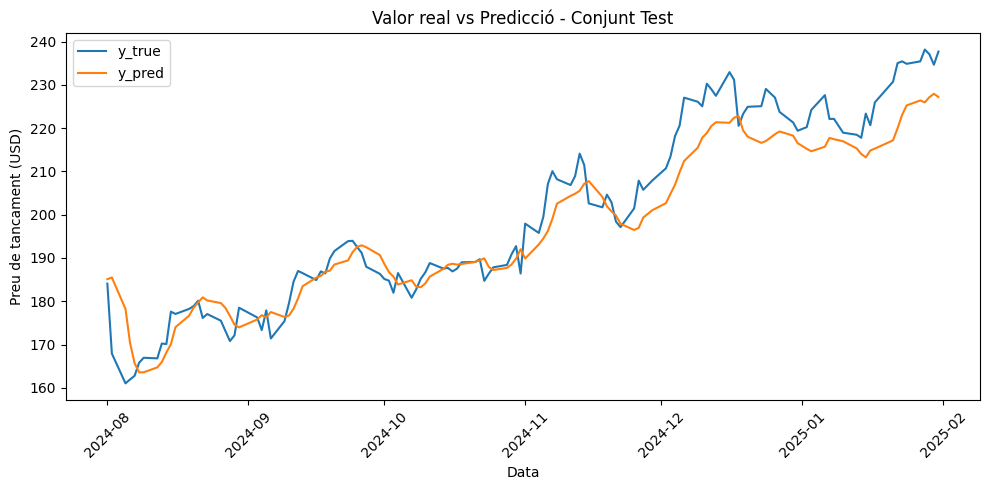

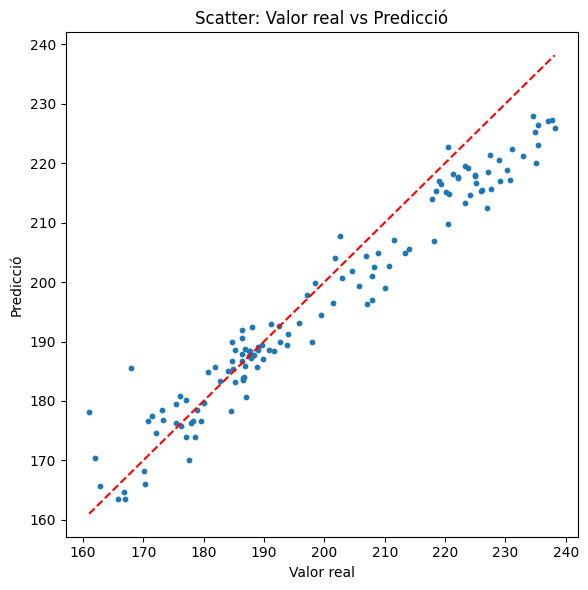

In [ ]:
dates_test = df['Date'].iloc[-len(y_true):].reset_index(drop=True)

# Gràfic de sèries temporals: valor real vs predicció amb dates a l’eix X
plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_true.flatten(), label="y_true")
plt.plot(dates_test, y_pred.flatten(), label="y_pred")
plt.title("Valor real vs Predicció - Conjunt Test")
plt.xlabel("Data")
plt.ylabel("Preu de tancament (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("experiment5_timeseries_with_dates.png")
plt.show()

# Scatter plot: manté Y veritat vs Y predicció (sense dates a l’eix X)
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=10)
plt.title("Scatter: Valor real vs Predicció")
plt.xlabel("Valor real")
plt.ylabel("Predicció")
# Línia x = y per referència
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig("experiment5_scatter.png")
plt.show()


In [ ]:
import os
import plotly.graph_objects as go
import plotly.io as pio


# Calcular prediccions escalades i invertir l’escala
y_pred_scaled = best_model.predict(X_test_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Extraure dates corresponents a l’interval de test (les darreres len(y_test_real) dates de df)
dates_test = df['Date'].iloc[-len(y_test_real):]

# Construir la figura amb Plotly
fig = go.Figure()

# Línia de valors reals
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_test_real.flatten(),
    mode='lines',
    name='Valor real (Close)',
    line=dict(color='blue')
))

# Línia de valors predits
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_pred.flatten(),
    mode='lines',
    name='Predicció',
    line=dict(color='red', dash='dash')
))

# Personalitzar layout
fig.update_layout(
    title='Predicció del Preu de les Accions (Amazon)',
    xaxis_title='Data',
    yaxis_title="Preu de l'acció (USD)",
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

# Crear carpeta si no existeix
output_dir = "LSTM"
os.makedirs(output_dir, exist_ok=True)

# Desa la figura com a HTML i PNG dins la carpeta
html_path = os.path.join(output_dir, "prediccio_lstm_amazon.html")

# Desa com a HTML
fig.write_html(html_path)


# Mostrar la gràfica en el navegador
pio.renderers.default = 'browser'
fig.show()

print(f"Gràfica desada com a:\n  - {html_path}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Gràfica desada com a:
  - LSTM\prediccio_lstm_amazon.html


PREDICCIÓ DEL PREU DE LES ACCIONS DELS 10 DIES SEGUENTS

In [33]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# ---------------------- 1) Funció per recalcular indicadors ----------------------

def recompute_indicators(df):

    close = df['Close']

    # EMA_7, EMA_40
    df['EMA_7'] = close.ewm(span=7, adjust=False).mean()
    df['EMA_40'] = close.ewm(span=40, adjust=False).mean()

    # MACD = EMA_12 - EMA_26, Signal line = EMA_9 de MACD
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    df['MACD'] = macd
    df['Signal_Line'] = signal
    df['MACD_Hist'] = macd - signal

    # RSI (14 dies)
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-8)
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR simplificat: rolling 14 dies de (High - Low)
    df['ATR'] = (df['High'] - df['Low']).rolling(window=14).mean()


# ---------------------- 2) Preparar DataFrame “futurible” ----------------------

# 2a) Copiar df i reset index
df_future = df.copy().reset_index(drop=True)

# 2b) Assegurar‐nos que df_future ja té tots els indicadors calculats
#     (en cas que estiguin buits per a l’última fila, els recalculem una sola vegada)
recompute_indicators(df_future)

# 2c) Agafar l’última finestra escalada de test per iniciar la predicció
input_window = X_test_scaled[-1].reshape(1, N_STEPS, n_features)

# 2d) Última data de df_future
last_date = df_future['Date'].iloc[-1]

# 2e) Generar les 10 dates laborables (skip caps de setmana)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

future_preds = []  # on guardarem les 10 prediccions reals


# ---------------------- 3) Iterar autoregressivament 10 dies ----------------------

for date in future_dates:
    # 3.1) Predir “Close” escalat i revertir escala
    y_pred_scaled = best_model.predict(input_window, verbose=0)   # shape = (1,1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)[0, 0]
    future_preds.append(y_pred)

    # 3.2) Construir la nova fila per df_future:
    prev = df_future.iloc[-1]
    new_row = {
        'Date':        date,
        'Open':        prev['Close'],   # usem l’últim Close com a Open
        'High':        y_pred,          # simplificació: High = predicció
        'Low':         y_pred,          # simplificació: Low = predicció
        'Volume':      prev['Volume'],  # mantenim volum de l’últim dia
        'Close':       y_pred,          # el nou Close és la predicció
        'EMA_7':       np.nan,          # recalcularem abaix
        'EMA_40':      np.nan,
        'MACD':        np.nan,
        'Signal_Line': np.nan,
        'MACD_Hist':   np.nan,
        'RSI':         np.nan,
        'ATR':         np.nan
    }

    # 3.3) Afegir la nova fila a df_future
    df_future.loc[len(df_future)] = new_row

    # 3.4) Recalcular indicadors en tot df_future (només l’última fila canviarà efectivament)
    recompute_indicators(df_future)

    # 3.5) Treure les últimes N_STEPS files de df_future[FEATURE_COLUMNS] per escalar
    last_features = df_future[FEATURE_COLUMNS].iloc[-N_STEPS:].values
    last_features_scaled = scaler_X.transform(last_features)  # shape (N_STEPS, n_features)

    # 3.6) Preparar la següent finestra d’input
    input_window = last_features_scaled.reshape(1, N_STEPS, n_features)


# ---------------------- 4) Mostrar per pantalla ----------------------

print(f"Prediccions de ‘Close’ pels propers {n_days} dies laborables:")
for dt, pred in zip(future_dates, future_preds):
    print(f"{dt.strftime('%Y-%m-%d')}: {pred:.2f} USD")


# ---------------------- 5) Visualització amb Plotly ----------------------

# 5a) Historical “Close”
dates_hist = df['Date']
close_hist = df['Close'].values

# 5b) Construir figura
fig = go.Figure()

# Dibuixar tota la sèrie històrica en blau clar
fig.add_trace(go.Scatter(
    x=dates_hist,
    y=close_hist,
    mode='lines',
    name='Històric Close',
    line=dict(color='lightblue')
))

# Dibuixar les 10 prediccions futures en taronja
fig.add_trace(go.Scatter(
    x=future_dates,
    y=np.array(future_preds),
    mode='lines+markers',
    name='Predicció futura Close',
    line=dict(color='orange', dash='dash'),
    marker=dict(size=6)
))

# Configurar layout perquè es vegi tot
fig.update_layout(
    title=f'Predicció del preu de tancament (Close) pels propers {n_days} dies laborables',
    xaxis_title='Data',
    yaxis_title='Preu de tancament (USD)',
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

pio.renderers.default = 'browser'
fig.show()

df_results = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_preds
})

# Desa el DataFrame a CSV
output_path = "LSTM/amazon_future_predictions.csv"
df_results.to_csv(output_path, index=False)

print(f"Resultats desats a {output_path}")

Prediccions de ‘Close’ pels propers 10 dies laborables:
2025-02-03: 227.19 USD
2025-02-04: 224.85 USD
2025-02-05: 221.75 USD
2025-02-06: 218.88 USD
2025-02-07: 216.29 USD
2025-02-10: 213.99 USD
2025-02-11: 212.00 USD
2025-02-12: 210.30 USD
2025-02-13: 208.88 USD
2025-02-14: 207.70 USD
Resultats desats a LSTM/amazon_future_predictions.csv
